In [4]:
import subprocess
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# 使用FFmpeg将视频转换为图片，每秒一帧

In [11]:
def extract_key_frames_ffmpeg(video_path, output_base_folder, frame_rate=1):
    """使用 FFmpeg 提取视频中的关键帧并将它们保存到以视频命名的文件夹中。

    Args:
        video_path (str): 视频文件的路径。
        output_base_folder (str): 存储所有关键帧文件夹的基础路径。
        frame_rate (int, optional): 提取关键帧的频率。默认每秒提取一帧。
    """
    video_name = os.path.basename(video_path).split('.')[0]
    output_folder = os.path.join(output_base_folder, video_name)
    
    # 创建视频对应的文件夹（如果不存在的话）
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    output_filename = os.path.join(output_folder, "frame_%d.jpg")
    cmd = f"./ffmpeg -i {video_path} -vf fps={frame_rate} {output_filename}"
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


def process_videos_with_ffmpeg(folder_path, output_folder, frame_rate=1):
    """使用 FFmpeg 处理文件夹中的所有视频，并显示进度条。

    Args:
        folder_path (str): 包含视频文件的文件夹路径。
        output_folder (str): 存储关键帧的文件夹路径。
        frame_rate (int, optional): 提取关键帧的频率。默认每秒提取一帧。
    """
    videos = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]

    with tqdm(total=len(videos), desc="Processing Videos") as pbar:
        for video in videos:
            extract_key_frames_ffmpeg(video, output_folder, frame_rate)
            pbar.update(1)

In [12]:
# 训练集和测试集的路径
train_videos_path = '../Data_Q3/train_video'
test_videos_path = '../Data_Q3/test_video'

# 输出文件夹
output_folder_train = '../Processed_Data_Q3/train_key_frames'
output_folder_test = '../Processed_Data_Q3/test_key_frames'

# 处理训练集和测试集中的视频
process_videos_with_ffmpeg(train_videos_path, output_folder_train)
process_videos_with_ffmpeg(test_videos_path, output_folder_test)


Processing Videos: 100%|██████████| 562/562 [01:01<00:00,  9.12it/s]


# Model

In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 读取标签文件
def load_labels(tag_file_path):
    labels_df = pd.read_csv(tag_file_path, header=None, names=['video', 'label'])
    labels_df['video'] = labels_df['video'].apply(lambda x: x.split('.')[0])  # 移除文件扩展名
    return labels_df

# 加载视频帧
def load_video_frames(video_folder_path, labels_df=None, frame_size=(64, 64), max_frames=20, load_labels=True):
    X, y = [], []
    for folder in os.listdir(video_folder_path):
        folder_path = os.path.join(video_folder_path, folder)
        if not os.path.isdir(folder_path):
            continue

        frames = []
        for frame_file in sorted(os.listdir(folder_path))[:max_frames]:
            frame_path = os.path.join(folder_path, frame_file)
            img = cv2.imread(frame_path)
            img = cv2.resize(img, frame_size)
            frames.append(img)

        while len(frames) < max_frames:  # 确保所有视频有相同数量的帧
            frames.append(np.zeros_like(frames[0]))

        X.append(frames)

        if load_labels and labels_df is not None:
            label = labels_df[labels_df['video'] == folder]['label'].values
            if len(label) > 0:
                y.append(label[0])
            else:
                y.append(-1)  # 对于无法找到标签的视频，可以使用一个占位符

    X = np.array(X).astype('float32') / 255.0  # 归一化
    if load_labels:
        y = to_categorical(y)  # 独热编码标签
        return X, y
    else:
        return X


tag_file_path = '../Data_Q3/tarin_tag.txt'  # 更改为您的 tag.txt 文件路径
train_key_frames_path = '../Processed_Data_Q3/train_key_frames'  # 更改为您的 train_key_frames 文件夹路径

labels_df = load_labels(tag_file_path)
X, y = load_video_frames(train_key_frames_path, labels_df)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

def build_model(num_classes):
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 64, 64, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model(num_classes=y.shape[1])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
52/52 [==============================] - 117s 2s/step - loss: 2.1468 - accuracy: 0.3376 - val_loss: 1.7906 - val_accuracy: 0.4189
Epoch 2/10
52/52 [==============================] - 117s 2s/step - loss: 2.0512 - accuracy: 0.3539 - val_loss: 1.7417 - val_accuracy: 0.4262
Epoch 3/10
52/52 [==============================] - 116s 2s/step - loss: 1.8958 - accuracy: 0.4024 - val_loss: 1.6332 - val_accuracy: 0.4891
Epoch 4/10
52/52 [==============================] - 116s 2s/step - loss: 1.7581 - accuracy: 0.4448 - val_loss: 1.5349 - val_accuracy: 0.4939
Epoch 5/10
52/52 [==============================] - 116s 2s/step - loss: 1.5973 - accuracy: 0.4782 - val_loss: 1.4367 - val_accuracy: 0.5157
Epoch 6/10
52/52 [==============================] - 115s 2s/step - loss: 1.4380 - accuracy: 0.5291 - val_loss: 1.4122 - val_accuracy: 0.5206
Epoch 7/10
52/52 [==============================] - 116s 2s/step - loss: 1.2685 - accuracy: 0.5794 - val_loss: 1.2959 - val_accuracy: 0.5642
Epoch 8/10
52

In [17]:
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

13/13 [==============================] - 2s 183ms/step - loss: 1.2569 - accuracy: 0.6174
Test loss: 1.256949782371521 / Test accuracy: 0.6174334287643433


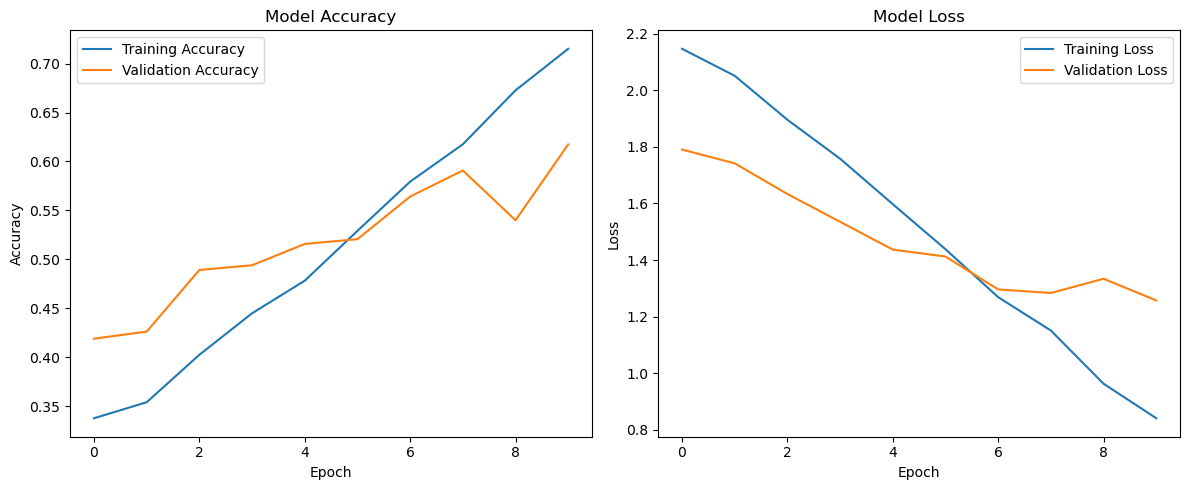

In [24]:
# Corrected code for plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
test_key_frames_path = '../Processed_Data_Q3/test_key_frames' 

# 使用与训练数据相同的函数加载测试数据
X_test = load_video_frames(test_key_frames_path, load_labels=False) 

In [28]:
# 使用训练好的模型进行预测
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

18/18 [==============================] - 3s 175ms/step


In [29]:

# 获取测试视频的文件名
test_video_names = [folder for folder in os.listdir(test_key_frames_path) if os.path.isdir(os.path.join(test_key_frames_path, folder))]

# 创建包含文件名和预测标签的 DataFrame
results_df = pd.DataFrame({
    'file_name': [name + '.mp4' for name in test_video_names],
    'label': predicted_labels
})


results_df

,file_name,label
0,602356487.mp4,7
1,838716540.mp4,11
2,897974621_70_80.mp4,2
3,879516906.mp4,3
4,748491221_220_230.mp4,7
...,...,...
557,543121627.mp4,9
558,872048877.mp4,3
559,501034834.mp4,12
560,837886335.mp4,10


TypeError: 'History' object is not subscriptable

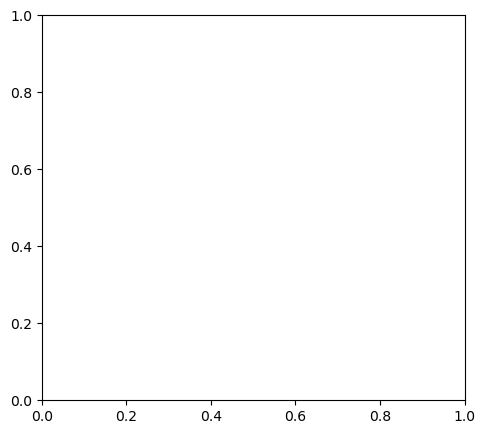

In [7]:
def organize_and_rename_files_by_category(original_data_path, tag_file_path, output_path):
    """
    Rename files by prefixing them with their folder name and then organize them into categories 
    based on a tag file.
    
    :param original_data_path: Path to the directory containing the original data folders.
    :param tag_file_path: Path to the tag file that maps folder names to categories.
    :param output_path: Path to the directory where the categorized folders will be created.
    """
    import os

    # Read and process the tag file
    tag_data = {}
    with open(tag_file_path, 'r') as file:
        for line in file:
            video_file, tag = line.strip().split(',')
            folder = video_file.split('.')[0]  # Removing the file extension
            tag_data[folder] = int(tag)

    # Create category directories
    for i in range(15):
        os.makedirs(os.path.join(output_path, str(i)), exist_ok=True)

    # Rename and move files to corresponding category folders
    for subdir in os.listdir(original_data_path):
        subdir_path = os.path.join(original_data_path, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                new_file_name = f"{subdir}_{file}"
                old_file_path = os.path.join(subdir_path, file)
                if subdir in tag_data:
                    tag = tag_data[subdir]
                    new_file_path = os.path.join(output_path, str(tag), new_file_name)
                    os.rename(old_file_path, new_file_path)

    print(f"Files have been renamed and organized into categories at {output_path}")

# Example usage of the function
original_data_path = '../Processed_Data_Q3/train_key_frames'  # Replace with your actual data path
tag_file_path = '../Data_Q3/tarin_tag.txt'                   # Replace with your actual tag file path
output_path = '../Category_Data'                             # Replace with your desired output categories path

# Uncomment the following line to run the function with your paths
organize_and_rename_files_by_category(original_data_path, tag_file_path, output_path)



Files have been renamed and organized into categories at ../Category_Data


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
data_dir = output_path  # Path to the directory with categorized images
image_size = (224, 224)  # Size to which images will be resized
batch_size = 32          # Number of images in each batch

# Initialize ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 0 images belonging to 15 classes.


In [2]:
tag_file = '../Data_Q3/tarin_tag.txt'  # 更改为您的 tag.txt 文件路径

labels = {}
with open(tag_file, 'r') as file:
    for line in file:
        video_name, label = line.strip().split(',')
        video_name = video_name.split('.')[0]  # 移除文件后缀
        labels[video_name] = int(label)



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# 图像生成器
train_datagen = ImageDataGenerator(
    # 数据增强和预处理设置
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

def generate_from_directory_with_labels(directory, labels, batch_size):
    generator = train_datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    while True:
        batch_x = next(generator)
        batch_filenames = generator.filenames
        batch_y = []

        for filename in batch_filenames:
            video_name = os.path.basename(os.path.dirname(filename))
            label = labels.get(video_name, None)
            if label is not None:
                batch_y.append(label)
            else:
                # 只在找不到标签时打印消息
                print(f"Label not found for video: {video_name}")

        # 检查批次大小是否正确
        if len(batch_y) == batch_size:
            yield batch_x, np.array(batch_y)
        else:
            # 只在批次大小不匹配时打印消息
            print("Batch size mismatch. Skipping batch.")




train_generator = generate_from_directory_with_labels(
    '../Processed_Data_Q3/train_key_frames',
    labels,
    batch_size=20
)


In [4]:
import matplotlib.pyplot as plt

# 获取生成器的一批数据
batch_x, batch_y = next(train_generator)

# 选择要显示的图像数量
num_images_to_show = 5

plt.figure(figsize=(15, 15))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(batch_x[i] * 255)  # rescale back to [0-255] range
    plt.title(f'Label: {batch_y[i]}')
    plt.axis('off')
plt.show()


Found 26264 images belonging to 2063 classes.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.
Batch size mismatch. Skipping batch.


KeyboardInterrupt: 